In [3]:
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define model

In [4]:
checkpoint = "distilbert-base-uncased"

In [5]:
class Lambda(nn.Module):
    """A neural network layer that applies the specified function to its inputs."""
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [6]:
def print_shape(x):
    print(x.shape)
    return x

def flatten(x):
    return x.view(x.shape[0], -1)

In [7]:
class RegressiveTransformer(nn.Module):
    TRANSFORMER_HIDDEN_SIZE = 768
    LINEAR_HIDDEN_SIZE = 500
    
    def __init__(self, num_tokens):
        super(RegressiveTransformer, self).__init__()
        self.base_model = AutoModel.from_pretrained(checkpoint)
        self.head = nn.Sequential(
            nn.Linear(self.TRANSFORMER_HIDDEN_SIZE, self.LINEAR_HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(self.LINEAR_HIDDEN_SIZE, 1),
            Lambda(flatten),
            nn.Linear(num_tokens, 1),
            Lambda(flatten),
            Lambda(lambda x: x.squeeze())
        )
        
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.base_model.to(device)
        self.head.to(device)
        
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids, attention_mask=attention_mask)
        outputs = self.head(outputs[0])
        
        loss = None
        if labels is not None:
            loss = self.loss(outputs, labels)
    
        return SequenceClassifierOutput(loss=loss, logits=outputs)
    
    def freeze_base(self):
        for param in self.base_model.parameters():
            param.requires_grad = False
    
    def unfreeze_base(self):
        for param in self.base_model.parameters():
            param.requires_grad = True
    
    def save(self, path):
        checkpoint = {
            'base': self.base_model.state_dict(),
            'head': self.head.state_dict(),
        }
        torch.save(checkpoint, path)
    
    def load(self, path):
        checkpoint = torch.load(path)
        self.base_model.load_state_dict(checkpoint['base'])
        self.head.load_state_dict(checkpoint['head'])

# Test Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

raw_inputs = [
    "Left left left",
    "Right right right",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")

In [ ]:
inputs

In [ ]:
num_tokens = inputs['input_ids'].shape[1]

In [ ]:
inputs['input_ids'].shape

In [ ]:
model = RegressiveTransformer(num_tokens)

outputs = model(**inputs)
print(outputs)
print(outputs.logits.size())

# Prep training/validation data

In [8]:
import pandas as pd
from datasets import Dataset

In [9]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [10]:
# Mini data
data_train = Dataset.from_csv('data/train-mini.csv')
data_valid = Dataset.from_csv('data/valid-mini.csv')

Using custom data configuration default-6fbf88325a2d299b
Reusing dataset csv (/home/.cache/huggingface/datasets/csv/default-6fbf88325a2d299b/0.0.0)
Using custom data configuration default-ffd76b52d9726235
Reusing dataset csv (/home/.cache/huggingface/datasets/csv/default-ffd76b52d9726235/0.0.0)


In [8]:
# Full data
data_train = Dataset.from_csv('data/train.csv')
data_valid = Dataset.from_csv('data/valid.csv')

Using custom data configuration default-16496940b3cae9e5
Reusing dataset csv (/home/.cache/huggingface/datasets/csv/default-16496940b3cae9e5/0.0.0)
Using custom data configuration default-7fec7a7bbca81e52
Reusing dataset csv (/home/.cache/huggingface/datasets/csv/default-7fec7a7bbca81e52/0.0.0)


In [11]:
def encode(sample):
    return tokenizer(sample['text'], padding=True, truncation=True)

In [12]:
data_train = data_train.map(encode, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [13]:
data_valid = data_valid.map(encode, batched=True)

Loading cached processed dataset at /home/.cache/huggingface/datasets/csv/default-ffd76b52d9726235/0.0.0/cache-165645ddba320e8e.arrow


In [14]:
data_train = data_train.remove_columns(['text'])
data_valid = data_valid.remove_columns(['text'])
data_train = data_train.rename_column('rating', 'labels')
data_valid = data_valid.rename_column('rating', 'labels')
data_train.set_format('torch')
data_valid.set_format('torch')

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(
    data_train,
    shuffle=True,
    batch_size=8,
    collate_fn=data_collator
)
valid_dataloader = DataLoader(
    data_valid,
    batch_size=8,
    collate_fn=data_collator
)

In [16]:
num_tokens = data_train['input_ids'].shape[1]

In [17]:
num_tokens

512

# Define Trainer

In [18]:
from transformers import get_scheduler
from tqdm.auto import tqdm

In [66]:
class Trainer:
    def __init__(self, model, train_dataloader, valid_dataloader, lr=0.00001, acc_thresh=0.1):
        self.model = model
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.optimizer = AdamW(model.parameters(), lr=lr)
        self.acc_thresh = acc_thresh
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    def train(self, num_epochs, max_batches=None):
        num_train_batches = min(len(self.train_dataloader), max_batches or float('inf'))
        num_valid_batches = min(len(self.valid_dataloader), max_batches or float('inf'))
        num_train_steps = num_epochs * num_train_batches
        num_valid_steps = num_epochs * num_valid_batches
        self.lr_scheduler = self.__get_scheduler(num_train_steps)
        
        losses = []
        accuracies = []
        
        self.train_progress = tqdm(range(num_train_steps))
        self.train_progress.set_description('Training')
        self.valid_progress = tqdm(range(num_valid_steps))
        self.valid_progress.set_description('Validation')
        for epoch in range(num_epochs):
            epoch_losses = self.__train(max_batches)
            epoch_accuracies = self.__eval(max_batches)
            losses.append(np.mean(epoch_losses))
            accuracies.append(np.mean(epoch_accuracies))
        
        return {
            'losses': losses,
            'accuracies': accuracies,
        }

    def __train(self, max_batches=None):
        losses = []
        model.train()
        for i, batch in enumerate(self.train_dataloader):
            if max_batches and i >= max_batches: break
            batch = {k: v.to(self.device) for k, v in batch.items()}
            outputs = self.model(**batch)
            loss = outputs.loss
            losses.append(loss.item())
            loss.backward()

            self.optimizer.step()
            self.lr_scheduler.step()
            self.train_progress.update(1)
        return losses

    def __eval(self, max_batches=None):
        accuracies = []
        model.eval()
        for i, batch in enumerate(self.valid_dataloader):
            if max_batches and i >= max_batches: break
            batch = {k: v.to(self.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = self.model(**batch)
            diffs = (batch['labels'] - outputs.logits).abs()
            num_correct = torch.count_nonzero(diffs.where(diffs < self.acc_thresh, torch.zeros_like(diffs)))
            accuracies.append((num_correct / float(batch['labels'].shape[0])).cpu())
            self.valid_progress.update(1)
        return accuracies

    def __get_scheduler(self, num_training_steps):
        return get_scheduler(
            "cosine",
            optimizer=self.optimizer,
            num_warmup_steps=50,
            num_training_steps=num_training_steps,
        )

# Train

In [50]:
def plot_results(results, smoothing_window=50):
    window = [1/smoothing_window] * smoothing_window
    plt.plot(np.convolve(results['losses'], window, 'valid'))
    plt.plot(np.convolve(results['accuracies'], window, 'valid'))
    plt.show()

In [79]:
model = RegressiveTransformer(num_tokens)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [80]:
model.freeze_base()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

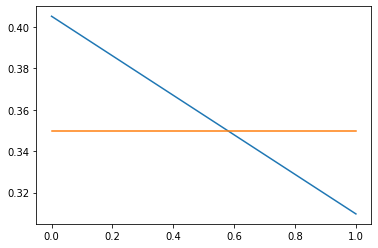

In [81]:
trainer = Trainer(model, train_dataloader, valid_dataloader, lr=0.00001, acc_thresh=0.2)
results = trainer.train(2, max_batches=10)
plot_results(results, 1)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

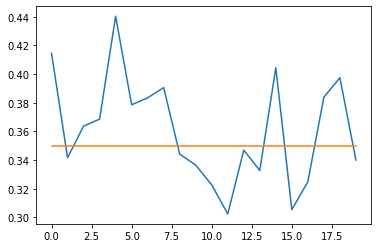

In [82]:
trainer = Trainer(model, train_dataloader, valid_dataloader, lr=0.00001, acc_thresh=0.2)
results = trainer.train(20, max_batches=10)
plot_results(results, 1)

In [84]:
model.unfreeze_base()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

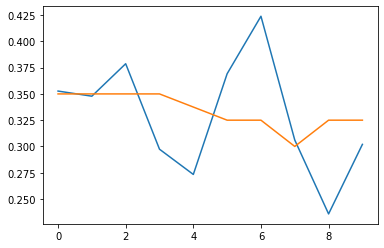

In [85]:
trainer = Trainer(model, train_dataloader, valid_dataloader, lr=0.00001, acc_thresh=0.2)
results = trainer.train(10, max_batches=10)
plot_results(results, 1)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

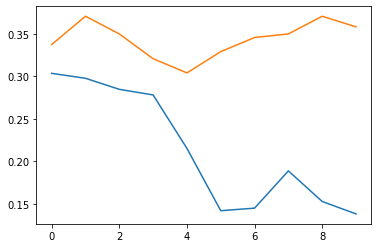

In [88]:
trainer = Trainer(model, train_dataloader, valid_dataloader, lr=0.00001, acc_thresh=0.2)
results = trainer.train(10, max_batches=30)
plot_results(results, 1)

In [ ]:
trainer = Trainer(model, train_dataloader, valid_dataloader, lr=0.00001, acc_thresh=0.2)
results = trainer.train(100, max_batches=30)
plot_results(results, 1)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



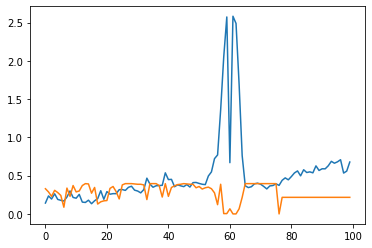

In [91]:
plot_results(results, 1)

In [ ]:
trainer = Trainer(model, train_dataloader, valid_dataloader, lr=0.000001, acc_thresh=0.2)
results = trainer.train(10, max_batches=30)
plot_results(results, 1)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
# Maybe we could plot the first five articles from the validation set?
# Or ideally the first of each bias

In [92]:
batch = next(iter(valid_dataloader)).to('cuda')
model(**batch)

SequenceClassifierOutput(loss=tensor(1.3006, device='cuda:0', grad_fn=<MseLossBackward0>), logits=tensor([-0.5427, -0.5427, -0.5427, -0.5427, -0.5427, -0.5427, -0.5426, -0.5427],
       device='cuda:0', grad_fn=<SqueezeBackward0>), hidden_states=None, attentions=None)

Next up:
- [ ] Hyperparameters - try a higher LR
- [ ] Tooling to report with larger batch size (ie. full data)
- [ ] Match up train and eval reporting size

What kind of visualisation approach could we use?

- The most natural would be to average stats per-epoch
- That's not very practical with our dataset size
- We could put a limit on num batches per epoch
- Since they're shuffled, we'll get a different sample of the data each time
- Then set a number of epochs to get the amount of training we desire
- Keep the validation set consistent